In [71]:
import copy
import os

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import sklearn

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl

In [72]:
ts_pd1_df = pd.read_csv('data/km_pd1_df.csv')
ts_pd1_df.head(4)

,Cancer Type,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,Bladder Cancer,0.989583,0.958168,0.909721,0.849800,0.803864,0.780046,0.737052,0.697211,0.682982,...,0.546154,0.504935,0.493459,0.481123,0.455800,0.414364,0.414364,0.414364,0.396348,0.396348
1,Colorectal Cancer,1.000000,0.979798,0.919192,0.876439,0.832062,0.787086,0.775160,0.713640,0.701120,...,0.539263,0.519290,0.519290,0.495686,0.495686,0.495686,0.495686,0.460280,0.460280,0.460280
2,Glioma,0.991228,0.982378,0.928794,0.893071,0.847966,0.775799,0.730164,0.702782,0.656547,...,0.422849,0.368638,0.297289,0.272515,0.245263,0.231637,0.204386,0.177135,0.144928,0.144928
3,Head and Neck Cancer,1.000000,0.977099,0.884775,0.828471,0.767426,0.740963,0.713854,0.666890,0.607169,...,0.406892,0.386547,0.386547,0.386547,0.358937,0.358937,0.326306,0.290050,0.217537,0.217537


In [73]:
# Row space test from Ken's notebook

# hard singular value thresholding (hsvt)
def hsvt(X, rank=2, return_all=False):
    """
    Input:
        X: donor data (#samples x #donor units)
        rank: #singular values of X to retain
    Output:
        low rank approximateion of X
    """
    if rank is None:
        return X
    u, s, v = np.linalg.svd(X, full_matrices=False)
    s[rank:].fill(0)
    if return_all:
        return np.dot(u * s, v), u[:,:rank], s[:rank], v[:rank,:]
    return np.dot(u * s, v)

def approximate_rank2(X, t = 0):
    """
    Input:
        X: donor data (#samples x #donor units)
        t: percentage of spectral energy to retain 
    Output:
        rank: approximate rank of X
    """
    _, s, _ = np.linalg.svd(X, full_matrices=False)
    b = X.shape[1]/X.shape[0]
    omega = 0.56*b**3-0.95*b**2+1.43+1.82*b
    thre = omega*np.median(s)
    rank = len(s[s>thre])
    return rank

def si_row_space_test(X_train, X_test):
    """
    Implements the row-space test described in one of the S-I papers.
    """

    k = approximate_rank2(X_train)
    X_train_hat, u1, s1, v1 = hsvt(X_train, rank=k, return_all=True)
    v1 = v1.T

    X_test_hat, u2, s2, v2 = hsvt(X_test, rank=k, return_all=True)   
    v2 = v2.T

    tau = np.linalg.norm(v2 - v1.dot(v1.T.dot(v2)), ord='fro')**2

    return tau, k    

In [74]:
def predict_and_plot(ts_pd1_df, target_type, moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2):
    other_types = list(ts_pd1_df['Cancer Type'])
    other_types.remove(target_type)
    months = [str(i) for i in range(moStart, moTestEnd + 1)]
    p = 1.0

    trainingMonths = [str(i) for i in range(moStart, moTrainEnd + 1)]
    testMonths = [str(i) for i in range(moTrainEnd + 1, moTestEnd + 1)]

    trainDataMasterDict = {}
    trainDataDict = {}
    testDataDict = {}
    for key in other_types:
      series = ts_pd1_df.loc[ts_pd1_df['Cancer Type'] == key]
      trainDataMasterDict.update({key: series[trainingMonths].values[0]})
      # randomly hide training data
      (trainData, pObservation) = tsUtils.randomlyHideValues(copy.deepcopy(trainDataMasterDict[key]), p)
      trainDataDict.update({key: trainData})
      testDataDict.update({key: series[testMonths].values[0]})
        
    series = ts_pd1_df[ts_pd1_df['Cancer Type'] == target_type]
    trainDataMasterDict.update({target_type: series[trainingMonths].values[0]})
    trainDataDict.update({target_type: series[trainingMonths].values[0]})
    testDataDict.update({target_type: series[testMonths].values[0]})

    trainMasterDF = pd.DataFrame(data=trainDataMasterDict)
    trainDF = pd.DataFrame(data=trainDataDict)
    testDF = pd.DataFrame(data=testDataDict)
    tau, k = si_row_space_test(trainDF, testDF)
    
    rscModel = RobustSyntheticControl(
        target_type, singvals, len(trainDF), probObservation=1.0, modelType='svd',
        svdMethod='numpy', otherSeriesKeysArray=other_types)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    
    predictions = []
    predictions = np.dot(testDF[other_types], rscModel.model.weights)
    actual = ts_pd1_df.loc[ts_pd1_df['Cancer Type'] == target_type][months]
    actual = actual.iloc[0]
    model_fit = np.dot(trainDF[other_types][:], rscModel.model.weights)   
    r2_score = sklearn.metrics.r2_score(actual[testMonths], predictions)
    
    fig, ax = plt.subplots(1,1)
    tick_spacing = 5
    # this is a bug in matplotlib
    label_markings = np.insert(months[::tick_spacing], 0, 'dummy')

    ax.set_xticks(np.arange(len(label_markings)))
    ax.set_xticklabels(label_markings, rotation=45)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    plt.plot(months, actual ,label='actual')
    plt.xlabel('Months after treatment')
    plt.ylabel('Survival rate')
    plt.plot(trainingMonths, model_fit, label='fitted model')
    plt.plot(testMonths, predictions, label='counterfactual')
    plt.title('\n'.join([
        target_type+' singular values used: '+str(singvals),
        'R2 score: %.4f'%r2_score + ', tau: %.6f'%tau
    ]))

    xposition = pd.to_datetime(moTrainEnd,  errors='coerce')
    plt.axvline(x=str(moTrainEnd), color='k', linestyle='--', linewidth=4)
    plt.grid()
    plt.legend()

## Non-Small Cell Lung Cancer

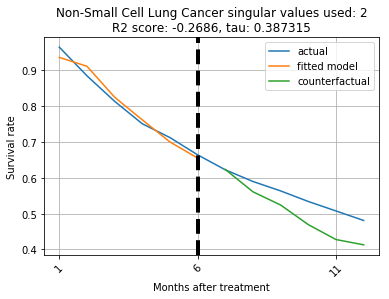

In [75]:
predict_and_plot(ts_pd1_df, 'Non-Small Cell Lung Cancer', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

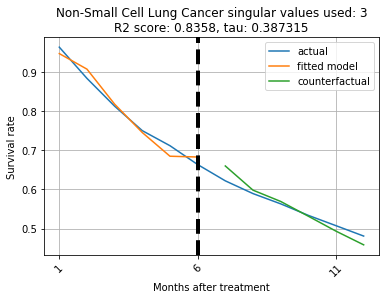

In [76]:
predict_and_plot(ts_pd1_df, 'Non-Small Cell Lung Cancer', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=3)

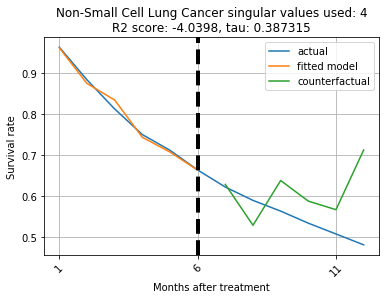

In [77]:
predict_and_plot(ts_pd1_df, 'Non-Small Cell Lung Cancer', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=4)

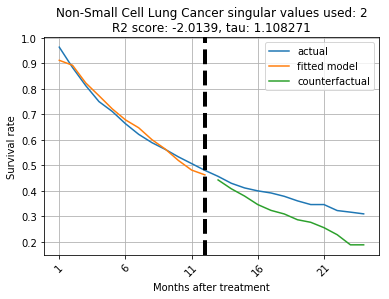

In [78]:
predict_and_plot(ts_pd1_df, 'Non-Small Cell Lung Cancer', moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)

## Melanoma

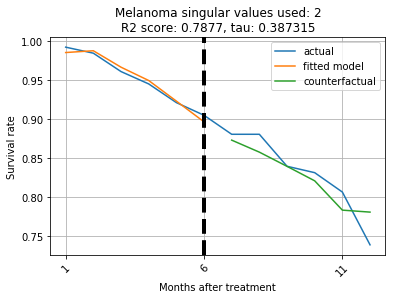

In [79]:
predict_and_plot(ts_pd1_df, 'Melanoma', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

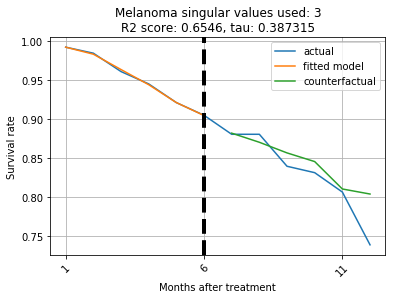

In [80]:
predict_and_plot(ts_pd1_df, 'Melanoma', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=3)

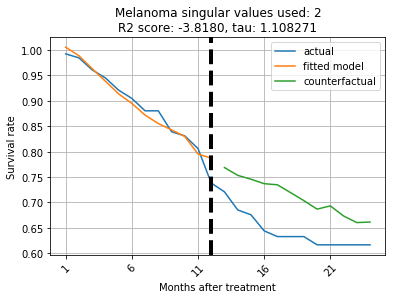

In [81]:
predict_and_plot(ts_pd1_df, 'Melanoma', moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)

## Colorectal Cancer

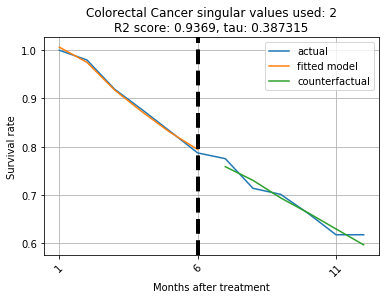

In [82]:
predict_and_plot(ts_pd1_df, 'Colorectal Cancer', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

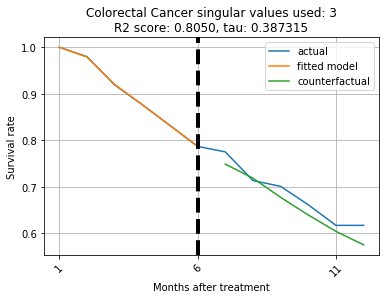

In [83]:
predict_and_plot(ts_pd1_df, 'Colorectal Cancer', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=3)

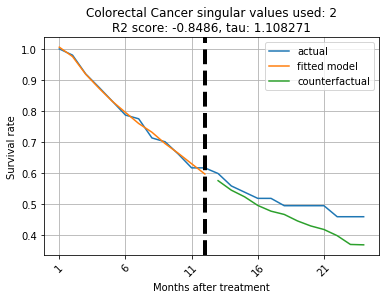

In [84]:
predict_and_plot(ts_pd1_df, 'Colorectal Cancer', moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)

## Bladder Cancer

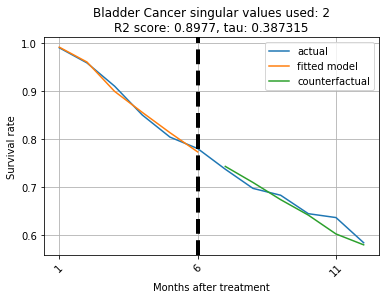

In [85]:
predict_and_plot(ts_pd1_df, 'Bladder Cancer', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

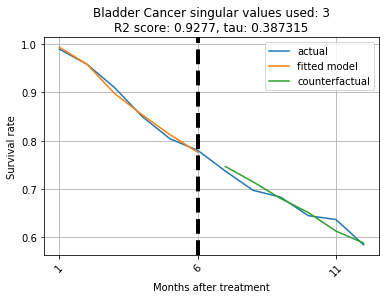

In [86]:
predict_and_plot(ts_pd1_df, 'Bladder Cancer', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=3)

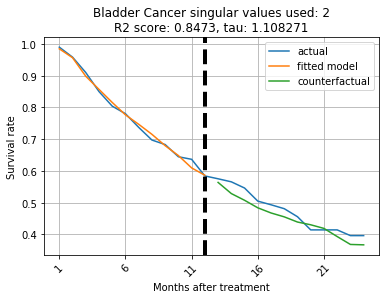

In [87]:
predict_and_plot(ts_pd1_df, 'Bladder Cancer', moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)

## Glioma

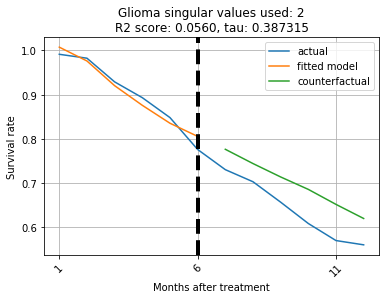

In [88]:
predict_and_plot(ts_pd1_df, 'Glioma', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=2)

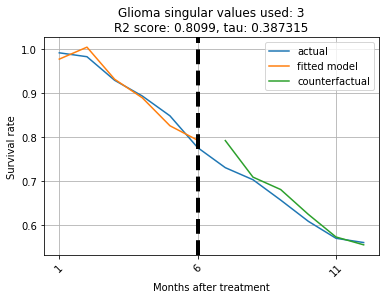

In [89]:
predict_and_plot(ts_pd1_df, 'Glioma', moStart=1, moTrainEnd=6, moTestEnd=12, singvals=3)

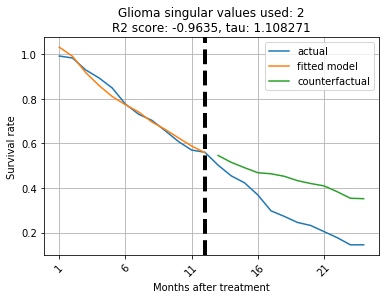

In [90]:
predict_and_plot(ts_pd1_df, 'Glioma', moStart=1, moTrainEnd=12, moTestEnd=24, singvals=2)